In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import altair as alt
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler
from scipy.spatial.distance import cdist

In [2]:
path = Path.home() / 'OneDrive - Seagroup/kaggle_dataset/OnlineRetail.csv'
df = pd.read_csv(path, encoding='ISO-8859-1')

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['diff_date'] = (max(df['InvoiceDate']) - df['InvoiceDate']).dt.days

df.eval('amount = UnitPrice * Quantity', inplace=True)

print(df.shape)
df.head()

(541909, 10)


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  diff_date  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom        373   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        373   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom        373   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        373   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        373   

   amount  
0   15.30  
1   20.34  
2   22.00  
3   20.34  
4   20.34

In [3]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
diff_date           0
amount              0
dtype: int64

In [4]:
df.dropna(inplace=True)

In [5]:
agg = {'diff_date': 'min', 'InvoiceNo': 'count', 'amount': 'sum'}
rfm = df.groupby('CustomerID').agg(agg).reset_index()
rfm.columns = ['CustomerID', 'r', 'f', 'm']
rfm.head()

CustomerID    r    f        m
0     12346.0  325    2     0.00
1     12347.0    1  182  4310.00
2     12348.0   74   31  1797.24
3     12349.0   18   73  1757.55
4     12350.0  309   17   334.40

In [6]:
chart1 = alt.Chart(rfm).transform_density(
    'r',
    as_=['r', 'density'],
).mark_area().encode(
    x='r',
    y='density:Q',
)

chart2 = alt.Chart(rfm).transform_density(
    'f',
    as_=['f', 'density'],
).mark_area().encode(
    x='f',
    y='density:Q',
)

chart3 = alt.Chart(rfm).transform_density(
    'm',
    as_=['m', 'density'],
).mark_area().encode(
    x='m',
    y='density:Q',
)

chart1 | chart2 | chart3

alt.HConcatChart(...)

In [7]:
rfm.describe()

CustomerID            r            f              m
count   4372.000000  4372.000000  4372.000000    4372.000000
mean   15299.677722    91.047118    93.053294    1898.459701
std     1722.390705   100.765435   232.471608    8219.345141
min    12346.000000     0.000000     1.000000   -4287.630000
25%    13812.750000    16.000000    17.000000     293.362500
50%    15300.500000    49.000000    42.000000     648.075000
75%    16778.250000   142.000000   102.000000    1611.725000
max    18287.000000   373.000000  7983.000000  279489.020000

In [8]:
rfm_col = ['r', 'f', 'm']

scaler = RobustScaler()
norm = scaler.fit_transform(rfm[rfm_col])
norm = pd.DataFrame(scaler.fit_transform(rfm[rfm_col]), columns=rfm_col)

print(norm.shape)
norm.head()

(4372, 3)


r         f         m
0  2.190476 -0.470588 -0.491576
1 -0.380952  1.647059  2.777631
2  0.198413 -0.129412  0.871661
3 -0.246032  0.364706  0.841555
4  2.063492 -0.294118 -0.237928

In [9]:
chart1 = alt.Chart(norm).transform_density(
    'r',
    as_=['r', 'density'],
).mark_area().encode(
    x='r',
    y='density:Q',
)

chart2 = alt.Chart(norm).transform_density(
    'f',
    as_=['f', 'density'],
).mark_area().encode(
    x='f',
    y='density:Q',
)

chart3 = alt.Chart(norm).transform_density(
    'm',
    as_=['m', 'density'],
).mark_area().encode(
    x='m',
    y='density:Q',
)

chart1 | chart2 | chart3

alt.HConcatChart(...)

In [10]:
def clusterByKMean(X, k):
    kmeans = KMeans(n_clusters=k).fit(X)
    return kmeans.labels_


def drawSilhouette(x, max_k):
    result = []
    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k).fit(x)
        labels = kmeans.labels_
        score = silhouette_score(x, labels, metric='euclidean')
        result.append((k, score))

    tmp = pd.DataFrame(result, columns=['k', 'score'])
    chart = alt.Chart(tmp).mark_line(point=True).encode(
        alt.X('k', scale=alt.Scale(zero=False)),
        alt.Y('score', scale=alt.Scale(zero=False)),
    ).properties(title='Silhouette Method')
    return chart, tmp

    
def drawElbow(x, max_k):
    result = []
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters = k).fit(x)
        labels = kmeans.labels_
        score = sum(np.min(cdist(x, kmeans.cluster_centers_, 'euclidean'), axis=1)) / np.shape(x)[0]
        result.append((k, score))
    
    tmp = pd.DataFrame(result, columns=['k', 'score'])
    chart = alt.Chart(tmp).mark_line(point=True).encode(
        alt.X('k', scale=alt.Scale(zero=False)),
        alt.Y('score', scale=alt.Scale(zero=False)),
    ).properties(title='Elbow Method')
    return chart, tmp

In [11]:
sil_chart, tmp_sil = drawSilhouette(norm, 10)
elb_chart, tmp_elb = drawElbow(norm, 10)

C:\Users\PC\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(


In [12]:
sil_chart | elb_chart

alt.HConcatChart(...)

In [13]:
rfm['cluster'] = clusterByKMean(norm, 4)
rfm['cluster'] = rfm['cluster'].astype(int).astype(str)
rfm.head()

CustomerID    r    f        m cluster
0     12346.0  325    2     0.00       0
1     12347.0    1  182  4310.00       0
2     12348.0   74   31  1797.24       0
3     12349.0   18   73  1757.55       0
4     12350.0  309   17   334.40       0

In [14]:
alt.Chart(rfm).mark_boxplot(size=60).encode(
    x='cluster',
    y='r',
    color='cluster'
).properties(width=300)

alt.Chart(...)

In [15]:
alt.Chart(rfm).mark_boxplot(size=60).encode(
    x='cluster',
    y='f',
    color='cluster'
).properties(width=300)

alt.Chart(...)

In [16]:
alt.Chart(rfm).mark_boxplot(size=60).encode(
    x='cluster',
    y='m',
    color='cluster'
).properties(width=300)

alt.Chart(...)

In [17]:
alt.Chart(rfm).mark_circle(size=20).encode(
    x='r',
    y='f',
    color='cluster',
    tooltip=['CustomerID', 'cluster', 'r', 'f'],
    column='cluster'
).properties()

alt.Chart(...)

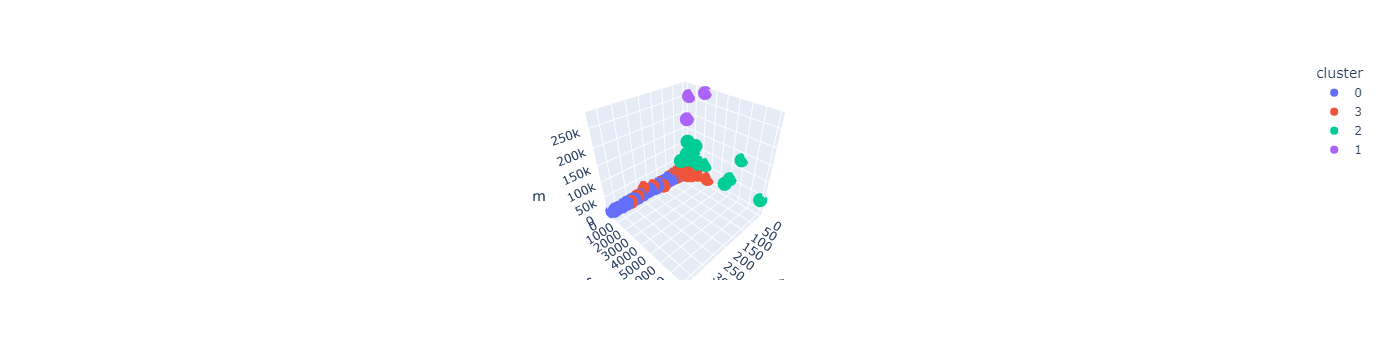

In [18]:
fig = px.scatter_3d(rfm, x='r', y='f', z='m', color='cluster')
fig.show()